# Biotuner sanity checks

This notebook illustrates the use of the *biotuner* toolbox with the aims to:
1. Showing that we can retrieve harmonic information from a signal that we have generated
2. Comparing harmonic structures from biological signals and noise signals
3. Comparing harmonic structures from biological signals and surrogated data

This notebook is one step towards the exploration of biological harmonies and their relevance for the carving of new musical systems, as compared to pseudo-random generative engines.

### Imports

In [1]:
import numpy as np
import math
from fractions import Fraction
import itertools
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
from biotuner.biotuner_object import *
from biotuner.biotuner2d import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import os
import time
import mne
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pygame 2.0.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Retrieving frequency information from simulated signals using the biotuner

First, we need to generate a signal composed of a set of predetermined frequencies

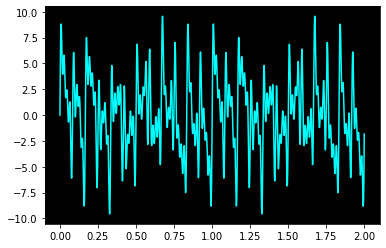

In [2]:
sf = 1000
length =2
theta = 0
freqs = [2, 6, 11, 12, 18, 24, 36, 48]
amps = [1, 2, 2, 2, 1, 2, 2, 2, 2]
    
signal = generate_signal(sf, length, freqs, amps, show=True, color = 'cyan')

Then, we want to retrieve the generator frequencies using different peaks_functions offered by the *biotuner*.

First, we will use the **'harmonic_peaks'** method, which select the spectral peaks that have higher number of other peaks as harmonics. 

In [3]:
biotuning = biotuner(sf = sf, peaks_function = 'harmonic_peaks', precision = 0.5) # Initialize biotuner object

biotuning.peaks_extraction(signal, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 1000)

print('RETRIEVED', biotuning.peaks, 'ORIGINAL', freqs)

RETRIEVED [ 6. 11. 18. 24. 36. 48.] ORIGINAL [2, 6, 11, 12, 18, 24, 36, 48]


We will do the same thing with the **'FOOOF'** method

In [4]:
biotuning = biotuner(sf = sf, peaks_function = 'FOOOF', precision = 0.5) # Initialize biotuner object

biotuning.peaks_extraction(signal, min_freq = 1, max_freq = 100)

FOOOF_peaks = biotuning.peaks
print('RETRIEVED', biotuning.peaks, 'ORIGINAL', freqs)

RETRIEVED [ 6. 24. 36.  2. 18.] ORIGINAL [2, 6, 11, 12, 18, 24, 36, 48]


And now with the **'fixed'** bands method. With the specified bands, we would expect to find *2, 6* and *24Hz*

In [5]:
FREQ_BANDS = [[1, 3], [4, 7], [20, 30]]
biotuning = biotuner(sf = sf, peaks_function = 'fixed', precision = 0.5) # Initialize biotuner object

biotuning.peaks_extraction(signal, FREQ_BANDS = FREQ_BANDS)

print('RETRIEVED', biotuning.peaks)

RETRIEVED [ 2.  6. 24.]


Finally using the Empirical Mode Decomposition (**'EMD'**) algorithm

In [6]:
biotuning = biotuner(sf = sf, peaks_function = 'EMD', precision = 0.5) # Initialize biotuner object

biotuning.peaks_extraction(signal)

EMD_peaks = biotuning.peaks
print('RETRIEVED', biotuning.peaks, 'ORIGINAL', freqs)

RETRIEVED [ 0.5  2.   4.  11.  24. ] ORIGINAL [2, 6, 11, 12, 18, 24, 36, 48]


#### We will add noise to the signal to see how the algorithms perform

NOISE LEVEL:  0


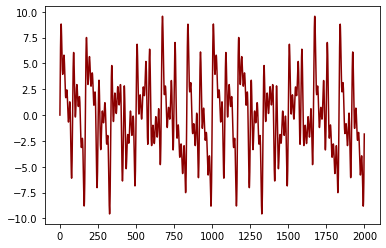

NOISE LEVEL:  5


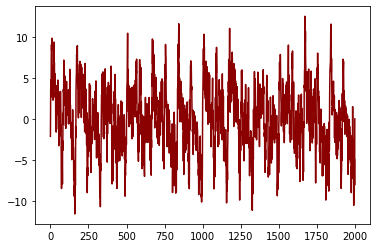

NOISE LEVEL:  10


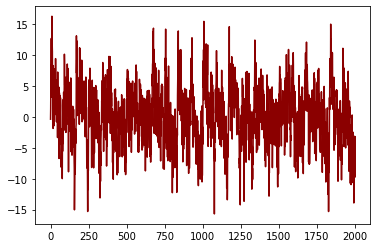

In [7]:
# Adding noise using a target noise power

# Set a target channel noise power to something very noisy
noise_db_list = range(0, 15, 5)
for db in noise_db_list:
    # Convert to linear Watt units
    target_noise_watts = 10 ** (db / 10)

    # Generate noise samples
    mean_noise = 0
    noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))

    # Noise up the original signal and plot
    noised_signal = signal + noise_signal
    if db == 0:
        plt.plot(signal, color = 'darkred')
    else:
        plt.plot(noised_signal, color = 'darkred')
    print('NOISE LEVEL: ', db)
    plt.show()

#### We will now quantify the effect of noise on peak detection by plotting the performance of the algorithms for different intensity of noise

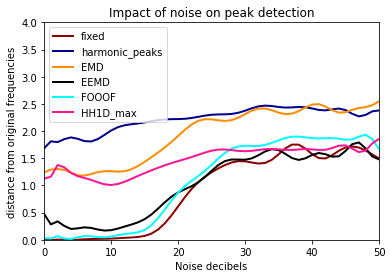

In [9]:
sf = 1000
length =2
n_times = 20 #number of times the bootstraping is executed
freqs = [2, 4, 8, 16, 32, 64]
freqs = [8, 16, 18, 24, 30, 32]
amps = [1, 1, 1, 1, 1, 1]
    
signal = generate_signal(sf, length, freqs, amps, show=False, color = 'turquoise')  
FREQ_BANDS = [[4, 12], [12, 17], [17, 22], [22, 26], [26, 31], [31, 40]]

peaks_methods = ['fixed', 'harmonic_peaks', 'EMD', 'EEMD', 'FOOOF','HH1D_max']
noise_db_list = range(0, 60, 1)
colors = ['darkred', 'darkblue', 'darkorange', 'black', 'cyan', 'deeppink']
for method, color in zip(peaks_methods, colors):
    avg_distance_tot = []
    for db in noise_db_list: 
        t = 0
        avg_distance = []
        while t < n_times:
            # Convert to linear Watt units
            target_noise_watts = 10 ** (db / 10)

            # Generate noise samples
            mean_noise = 0
            noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))

            # Noise up the original signal and plot
            noised_signal = signal + noise_signal

            biotuning = biotuner(sf = sf, peaks_function = method, precision = 0.1) # Initialize biotuner object
            biotuning.peaks_extraction(noised_signal, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 128, 
                                       FREQ_BANDS = FREQ_BANDS)
            biotuning.peaks = [x for x in biotuning.peaks if x <= freqs[-1]]
            if db == 0:
                no_noise_peaks = biotuning.peaks
            list_distance = []
            for p in biotuning.peaks:
                takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
                closest = takeClosest(p,freqs)
                list_distance.append(abs(p-closest))   
            avg_distance.append(np.average(list_distance))
            t += 1
        avg_distance_tot.append(np.average(avg_distance))
        
    z = np.polyfit(noise_db_list, avg_distance_tot, len(noise_db_list))
    p = np.poly1d(z)
    #plt.plot(noise_db_list, p(noise_db_list), avg_distance, "r-o", color = 'darkturquoise')
    plt.plot(noise_db_list, p(noise_db_list), color = color, linewidth=2, label=method)
    #plt.plot(noise_db_list, avg_distance, '--', color = color, linewidth=1)
    
    
plt.xlabel("Noise decibels")
plt.ylabel("distance from original frequencies")
plt.title('Impact of noise on peak detection')
plt.grid = True
plt.ylim((0,4))
plt.xlim((0,50))
plt.legend(loc="upper left")
plt.show()
        #print(biotuning.peaks)




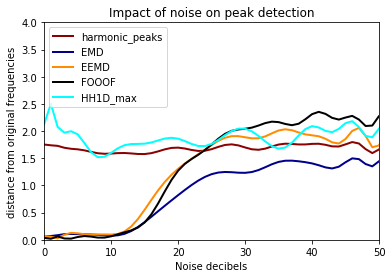

In [11]:
sf = 1000
length =2
n_times = 20 #number of times the bootstraping is executed
freqs = [2, 4, 8, 16, 32, 64]
freqs = [2, 3.6, 9.2, 13.3, 21.4, 34.5]
amps = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    
signal = generate_signal(sf, length, freqs, amps, show=False, color = 'turquoise')  
FREQ_BANDS = [[4, 12], [12, 17], [17, 22], [22, 26], [26, 31], [31, 40]]

peaks_methods = ['harmonic_peaks', 'EMD', 'EEMD', 'FOOOF','HH1D_max']
noise_db_list = range(0, 60, 1)
colors = ['darkred', 'darkblue', 'darkorange', 'black', 'cyan', 'deeppink']
for method, color in zip(peaks_methods, colors):
    avg_distance_tot = []
    for db in noise_db_list: 
        t = 0
        avg_distance = []
        while t < n_times:
            # Convert to linear Watt units
            target_noise_watts = 10 ** (db / 10)

            # Generate noise samples
            mean_noise = 0
            noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))

            # Noise up the original signal and plot
            noised_signal = signal + noise_signal

            biotuning = biotuner(sf = sf, peaks_function = method, precision = 0.1) # Initialize biotuner object
            biotuning.peaks_extraction(noised_signal, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 128, 
                                       FREQ_BANDS = FREQ_BANDS)
            biotuning.peaks = [x for x in biotuning.peaks if x <= freqs[-1]]
            if db == 0:
                no_noise_peaks = biotuning.peaks
            list_distance = []
            for p in biotuning.peaks:
                takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
                closest = takeClosest(p,freqs)
                list_distance.append(abs(p-closest))   
            avg_distance.append(np.average(list_distance))
            t += 1
        avg_distance_tot.append(np.average(avg_distance))
        
    z = np.polyfit(noise_db_list, avg_distance_tot, len(noise_db_list))
    p = np.poly1d(z)
    #plt.plot(noise_db_list, p(noise_db_list), avg_distance, "r-o", color = 'darkturquoise')
    plt.plot(noise_db_list, p(noise_db_list), color = color, linewidth=2, label=method)
    #plt.plot(noise_db_list, avg_distance, '--', color = color, linewidth=1)
    
    
plt.xlabel("Noise decibels")
plt.ylabel("distance from original frequencies")
plt.title('Impact of noise on peak detection')
plt.grid = True
plt.ylim((0,4))
plt.xlim((0,50))
plt.legend(loc="upper left")
plt.show()
        #print(biotuning.peaks)




## Comparing EEG data with noise and surrogate data 

One question that rises when using the Biotuner is whether the harmonic information that is retrieved on biological signals is different than if we were using comparable non-biological signals, such as noises and surrogated data

<img src="images/noise_color.png" width=500 height=500 />

The ***graph_surrogates*** function allows to compare the distribution of harmonicity metrics for EEG, surrogates and noise data. 

**------------------------- TYPES OF SIMULATED SIGNALS -----------------------------------------**

**NOISES**

**brown noise** : noise with a slope of 1/f^2

**pink noise** : noise with a slope of 1/f^1

**white noise** : noise with a slope of 1/f^0

**blue noise** : noise with a slope of 1/f^-1

**SURROGATES**

**shuffle** : the time series is randomly shuffled and filtered as the original time series

**phase** : the phase information of the signal is shuffled

**AAFT** : noise with a slope of 1/f^1

**TFT** : truncated-fourier-transform; randominzing the frequencies phases above a certain threshold (Nakamura, Small and Hirata, 2006)


**------------------------- HARMONIC METRICS -----------------------------------------**

*Peaks metrics* that can be used: **'tenney', 'harmsim', 'euler', 'cons', 'harm_fit'**

*Scale metrics* that can be used (using the scale from *peaks ratios*): **'sum_p_q', 'sum_distinct_intervals', 'sum_q_for_all_intervals', 'matrix_harm_sim', 'matrix_cons'**

*Scale metrics* that can be used (using the scale from *dissonance curve*): **'dissonance', 'diss_n_steps', 'diss_harm_sim'**

*Timepoint consonance metrics* that can be used: **'n_IF_chords'**, **'n_spectro_chords'**

## Using Sleep data
#### Load the 'sleep_data.npy' file from the eeg_data folder. These data are from : https://www.physionet.org/content/sleep-edfx/1.0.0/

In [38]:
sleep_data = np.load('eeg/sleep_data_Cz.npy', allow_pickle = True)
sleep_conditions = ['wake', 'stage1', 'stage2', 'stage3', 'stage4', 'REM']

### Comparing EEG signal to colored noises

EEG signal during wakefulness is compared with ***brown, pink, white*** and ***blue noise*** simulated signals using ***'fixed', 'adapt'*** and ***'EEMD'*** peaks_functions

fixed  peaks freqs  [13.542105263157895, 12.479425837320573, 15.328708133971292, 18.25215311004785, 11.706698564593301]


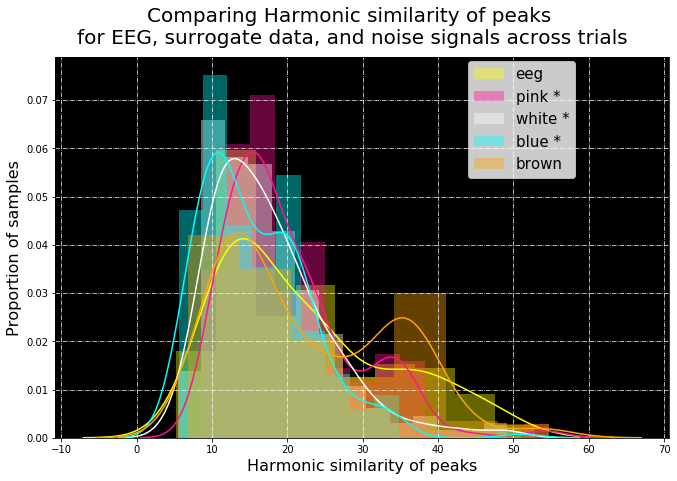

adapt  peaks freqs  [11.213397129186603, 11.275598086124399, 14.101913875598086, 16.90622009569378, 9.782775119617225]


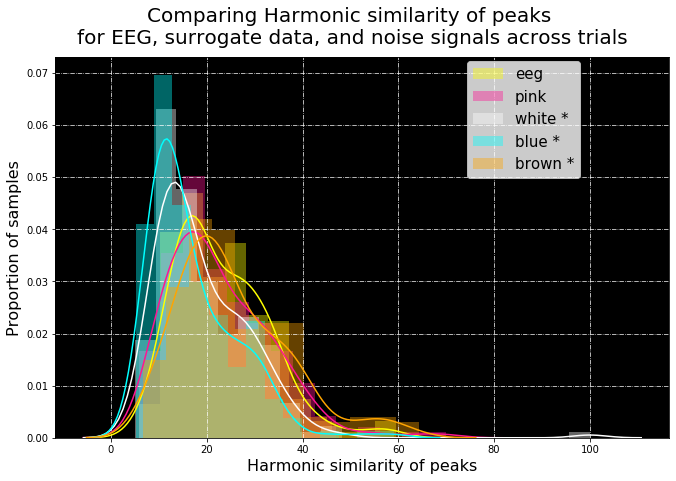

EEMD  peaks freqs  [3.8382775119617225, 4.607177033492824, 5.8220095693779905, 6.767464114832537, 3.4100478468899524]


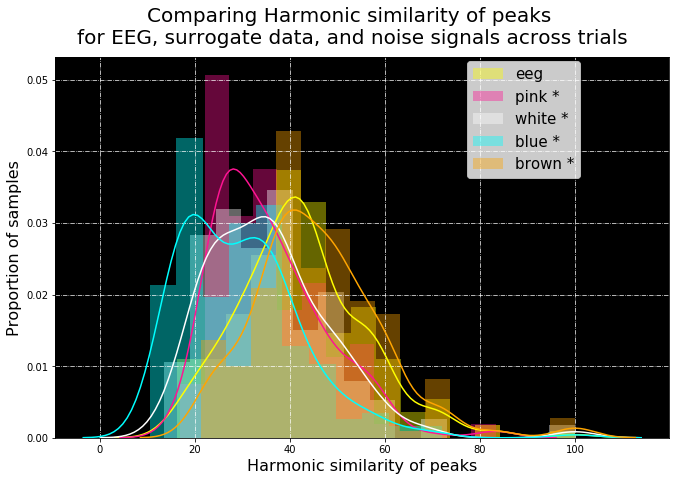

In [40]:
peaks_functions = ['fixed', 'adapt', 'EEMD']
sf = 100
for p in peaks_functions:  
    colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
    conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
    metric_to_graph = 'harmsim'
    data = np.array(sleep_data[0], dtype='float64')
    graph_surrogates(data, sf, conditions, metric_to_graph = metric_to_graph, peaks_function = p, precision = 0.5, 
                     savefolder = None, low_cut = 1, high_cut = (sf/2)-0.1, 
                    display = True, save = False, colors = colors)

### Comparing EEG signal to surrogated data

EEG signal during wakefulness is compared with ***surrogated data*** using ***'EMD'*** and ***'EEMD'*** peaks_functions

EMD  peaks freqs  [2.1857416267942584, 3.792822966507177, 2.1355023923444976, 2.3309090909090906, 2.347751196172249]


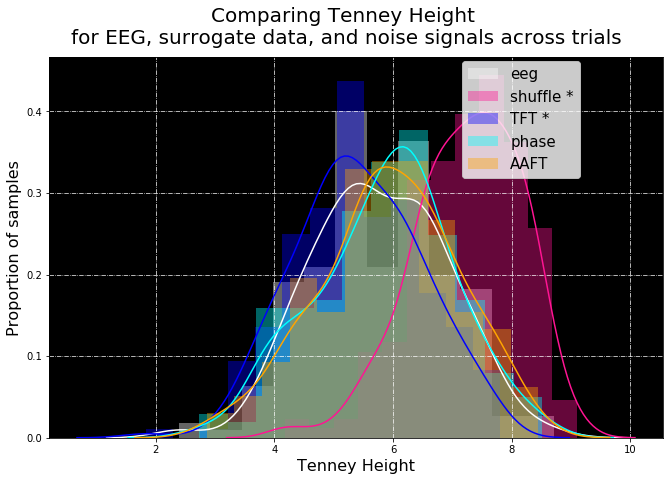

In [ ]:
peaks_functions = ['EMD']
metrics = ['tenney', 'harmsim', 'sum_q_for_all_intervals']
sf = 100
for metric in metrics:
    for p in peaks_functions:  
        colors = ['white', 'deeppink', 'blue', 'cyan', 'orange'] 
        conditions = ['eeg', 'shuffle', 'TFT', 'phase', 'AAFT']
        data = np.array(sleep_data[0], dtype='float64')
        graph_surrogates(data, sf, conditions, metric_to_graph = metric, peaks_function = p, precision = 0.1, 
                         savefolder = None, low_cut = 1, high_cut = (sf/2)-0.1, 
                        display = True, save = False, colors = colors)

## Using pareidolia data

*Peaks metrics* that can be used: **'tenney', 'harmsim', 'euler', 'cons', 'harm_fit'**

*Scale metrics* that can be used (using the scale from peaks ratios): **'sum_p_q', 'sum_distinct_intervals', 'sum_q_for_all_intervals', 'matrix_harm_sim', 'matrix_cons'**

*Scale metrics* that can be used (using the scale from dissonance curve): **'dissonance', 'diss_n_steps', 'diss_harm_sim'**

*Timepoint consonance metrics* that can be used: **'n_IF_chords'**, **'n_spectro_chords'**

### Comparing EEG signal to colored noises

EEG signal is compared with ***brown, pink, white*** and ***blue noise*** simulated signals using ***'harmonic_peaks'*** and ***'EEMD'*** peaks_function

harmonic_peaks  peaks freqs  [10.278530219780219, 10.05915750915751, 19.49459706959707, 28.59478021978022, 8.198489010989011]


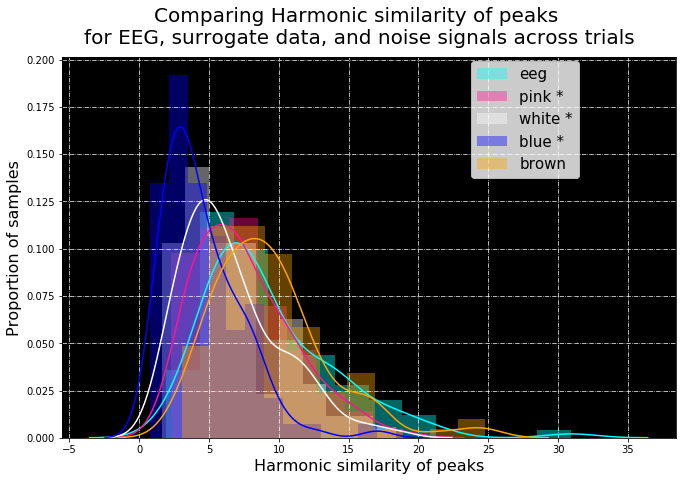

harmonic_peaks  peaks freqs  [10.278530219780219, 9.438324175824176, 18.2860347985348, 28.550137362637358, 8.256730769230769]


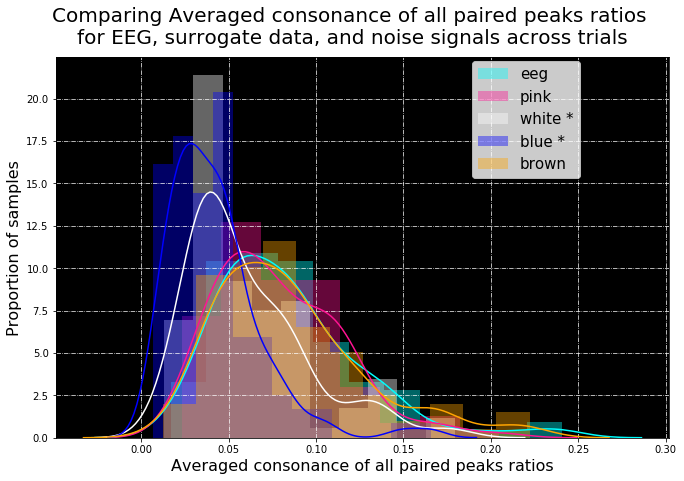

harmonic_peaks  peaks freqs  [10.278530219780219, 9.535989010989011, 19.4385989010989, 28.111181318681318, 8.598214285714285]


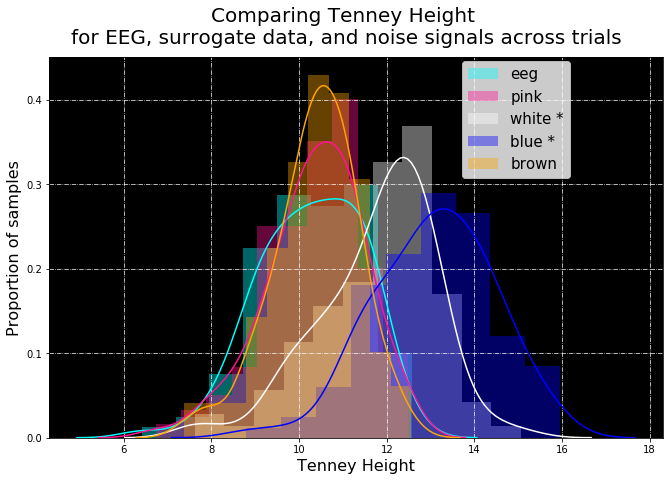

EEMD  peaks freqs  [11.323269230769231, 16.810384615384617, 21.93653846153846, 26.75788461538462, 11.724615384615383]


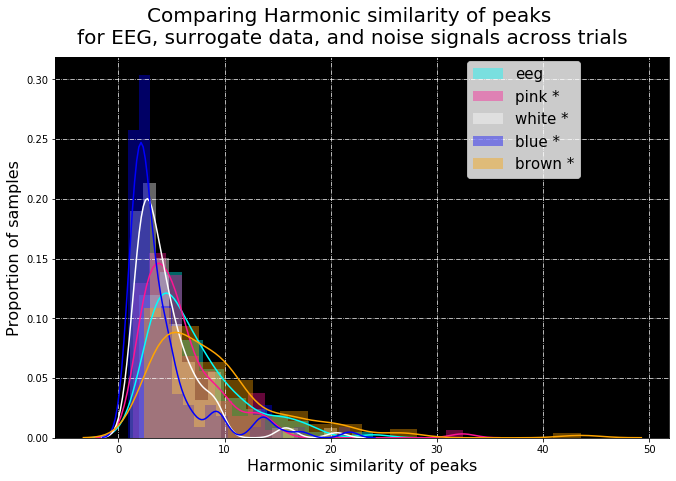

EEMD  peaks freqs  [11.323269230769231, 17.208076923076923, 22.305384615384614, 27.075576923076923, 11.855192307692308]


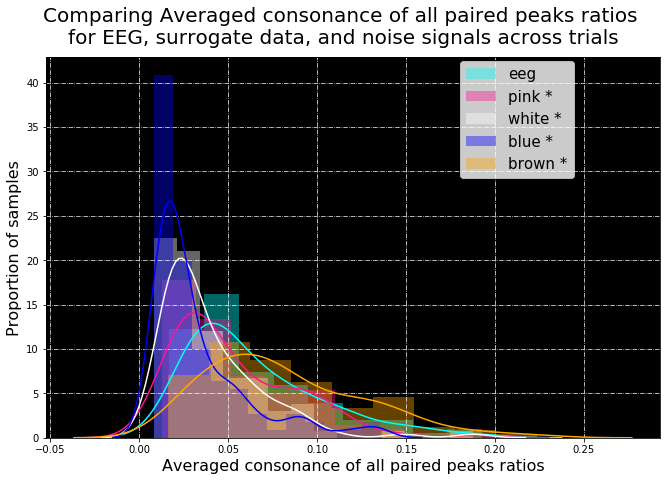

EEMD  peaks freqs  [11.323269230769231, 17.224230769230772, 22.49557692307692, 27.059807692307693, 11.329615384615384]


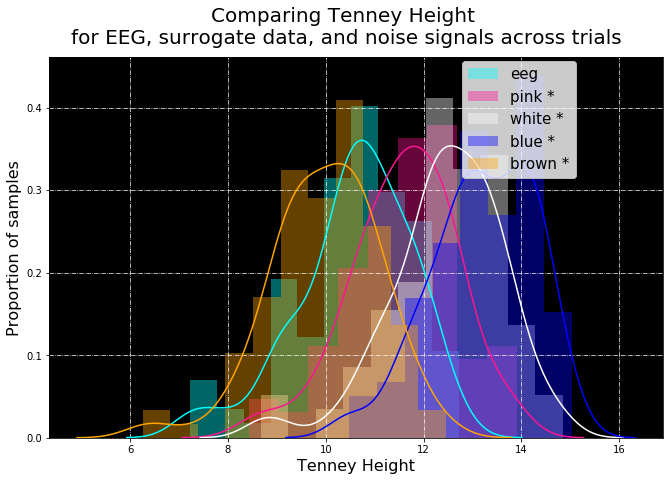

In [43]:
channels= ['O2']
peaks_functions = ['harmonic_peaks', 'EEMD']
metrics = ['harmsim', 'cons', 'tenney']
sf = 1000
colors = ['cyan', 'deeppink', 'white', 'blue', 'orange', 'yellow'] 
for p in peaks_functions:
    for channel in channels: 
        for metric in metrics:
            #conditions = ['eeg', 'pink', 'white', 'AAFT', 'phase', 'TFT']
            conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
            metric_to_graph = metric
            data = np.load('eeg/pareidolia_data_'+channel+'.npy')
            graph_surrogates(data, sf = sf, conditions = conditions, metric_to_graph=metric_to_graph, 
                             peaks_function = p, precision = 0.1, savefolder = '_', tag = channel, 
                             low_cut = 0.5, high_cut = 150, colors = colors, save = False, display = True,
                            n_harmonic_peaks = 7)

### Comparing EEG signal to surrogated data

EEG signal is compared with ***surrogated data*** using ***'EMD'*** and ***'EEMD'*** peaks_functions

EMD  peaks freqs  [7.532692307692307, 8.068269230769232, 7.505, 7.966153846153846, 14.989807692307693]


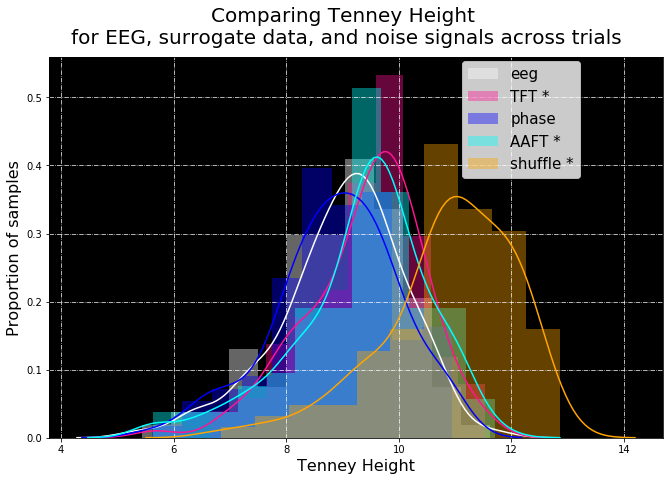

EMD  peaks freqs  [7.532692307692307, 8.068269230769232, 7.590769230769231, 7.624615384615385, 14.848653846153848]


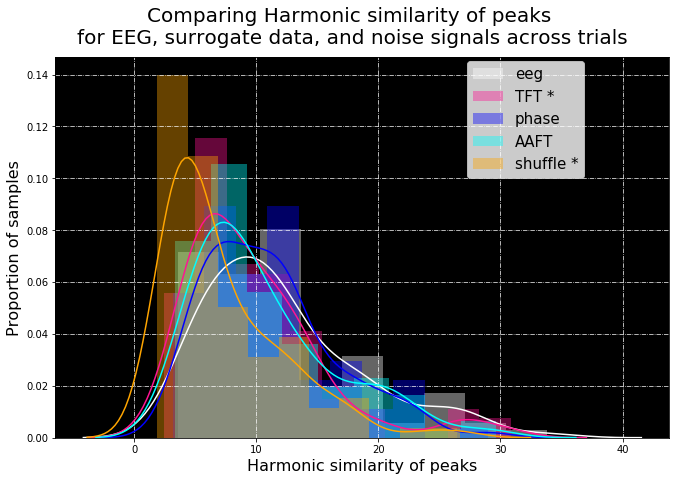

EMD  peaks freqs  [7.532692307692307, 8.068269230769232, 7.720961538461538, 7.719038461538461, 15.226346153846153]


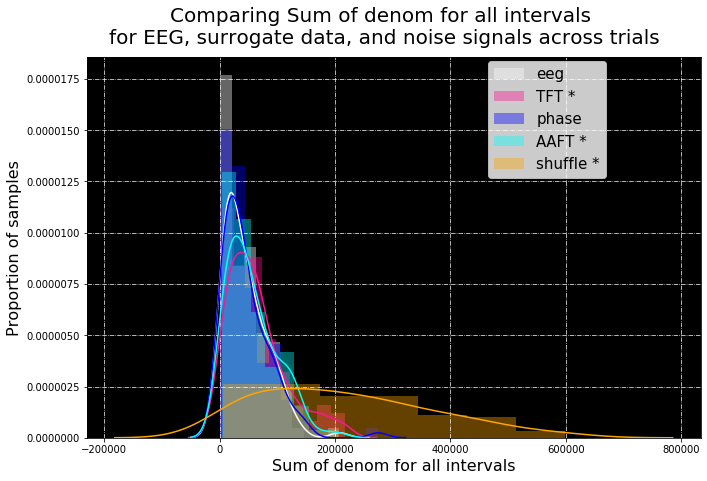

EMD  peaks freqs  [7.532692307692307, 8.068269230769232, 7.519615384615384, 7.6315384615384625, 15.074038461538464]


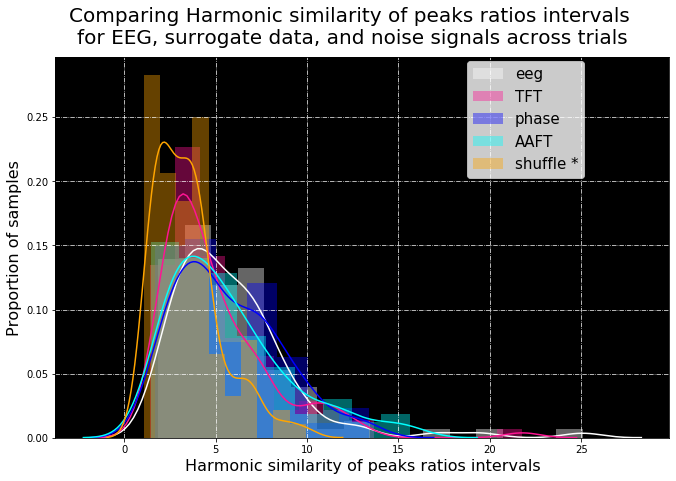

In [50]:
channels= ['O1']
savefolder = 'C:/Users/Dell/GitHub/biotuner_dev/dev/graphs/pareidolia/' #Choose your folder the save the images
peaks_functions = ['EMD']
metrics = ['tenney', 'harmsim', 'sum_q_for_all_intervals', 'matrix_harm_sim']
sf = 1000
colors = ['white', 'deeppink', 'blue', 'cyan', 'orange'] 
for p in peaks_functions:
    for channel in channels: 
        for metric in metrics:
            #conditions = ['eeg', 'pink', 'white', 'AAFT', 'phase', 'TFT']
            conditions = ['eeg', 'TFT', 'phase', 'AAFT', 'shuffle']
            metric_to_graph = metric
            data = np.load('eeg/pareidolia_data_'+channel+'.npy')
            graph_surrogates(data, sf = sf, conditions = conditions, metric_to_graph=metric, 
                             peaks_function = p, precision = 0.1, savefolder = savefolder, tag = channel, 
                             low_cut = 0.5, high_cut = 150, colors = colors, save = False, display = True)

## Comparing timepoint consonance

Timepoint consonance corresponds to moments in time when the frequencies from different subcomponents of the signal reach a certain consonance level. 

They can be derived by computing the 'spectral centroid' of successive windows for each of the intrinsic mode functions of the signal (IMFs). This is used when the metrics **n_spectro_chords** is chosen. 
When using this metric, the choice of the peaks_function does not impact the result because the *EMD* is used the decompose the signal in any case.

They also can be derived by computing the instantaneous frequency (IF) of each IMF and estimating the consonance for each moment in time. This is used when the metrics **n_IF_chords** is chosen. When using this metric, the peaks_function **HH1D_max** needs to be chosen


In [3]:
path = 'data_examples/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_data_ = []
for i in range(len(EEG_data)):
    EEG_data_.append(EEG_data[i][1000:3000])
EEG_data = np.array(EEG_data_)

Here, we compared **eeg signal** with **noise signals** with *n_spectro_chords* metric. A spectral chord was considered when at least **2** IMFs (*min_notes* argument) reach the consonance threshold (*cons_limit* argument) 

fixed  peaks freqs  [13.229599999999998, 14.2992, 15.573600000000003, 16.6004, 13.1072]


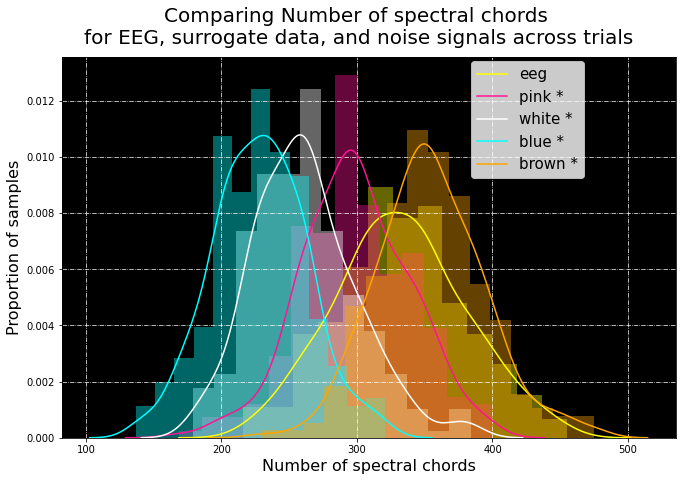

In [14]:
data = EEG_data[100:350]
colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
metric_to_graph = 'n_spectro_chords'
graph_surrogates(data, 1000, conditions, metric_to_graph = metric_to_graph, peaks_function = 'fixed', precision = 0.5, 
                 savefolder = None, low_cut = 2, high_cut = 150, 
                display = True, save = False, colors = colors, n_harmonic_peaks = 5, min_notes=2, cons_limit=0.1)

Here, we changed the **min_notes** argument to 3 instead of 2 

fixed  peaks freqs  [13.229599999999998, 14.315199999999999, 15.454799999999999, 16.7144, 13.2844]


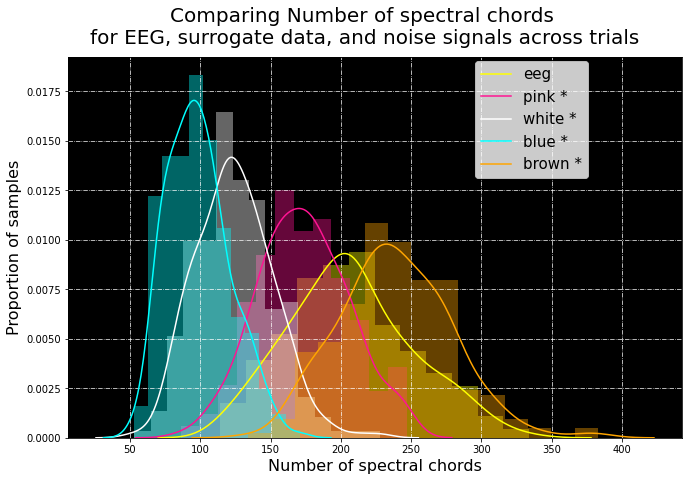

In [13]:
data = EEG_data[100:350]
colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
metric_to_graph = 'n_spectro_chords'
graph_surrogates(data, 1000, conditions, metric_to_graph = metric_to_graph, peaks_function = 'fixed', precision = 0.5, 
                 savefolder = None, low_cut = 2, high_cut = 150, 
                display = True, save = False, colors = colors, n_harmonic_peaks = 5, min_notes=3, cons_limit=0.1)

#### Here, we compared the distribution of *spectro_chords* from temporal (T8), parietal (C4) and occipital (O2) electrodes

T8
C4
O2
fixed  peaks freqs  [14.370192307692308, 13.787500000000001, 13.110576923076923]


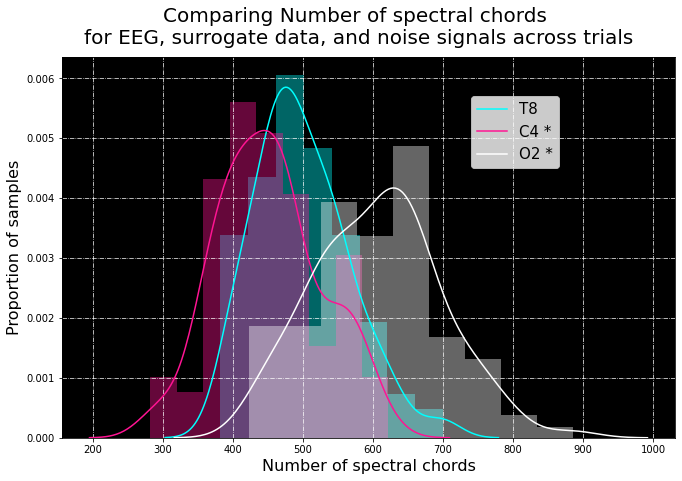

In [5]:
channels= ['T8', 'C4', 'O2']
peaks_function = 'fixed'
metric_to_graph = 'n_spectro_chords'
sf = 1000
data_O2 = np.load('data_examples/pareidolia_data_'+channels[0]+'.npy')
data_T8 = np.load('data_examples/pareidolia_data_'+channels[1]+'.npy')
data_C4 = np.load('data_examples/pareidolia_data_'+channels[2]+'.npy')
data_all = [data_O2, data_T8, data_C4]
colors = ['cyan', 'deeppink', 'white', 'blue', 'orange', 'yellow'] 


graph_conditions(data_all, sf = sf, conditions = channels, metric_to_graph=metric_to_graph, 
                 peaks_function = peaks_function, precision = 0.5, savefolder = '_', tag = '_', 
                 low_cut = 0.5, high_cut = 150, colors = colors, save = False, display = True,
                n_harmonic_peaks = 7, min_notes=3, cons_limit=0.1)

Here, we compared the distribution of *spectro_chords* from temporal (T7), parietal (C3) and occipital (O1) electrodes to evaluate consistency of results. We see that occipital electrodes seem to produce higher number of spectral chords than other the other electrodes

T7
C3
O1
fixed  peaks freqs  [13.745192307692308, 13.688461538461537, 13.032692307692308]


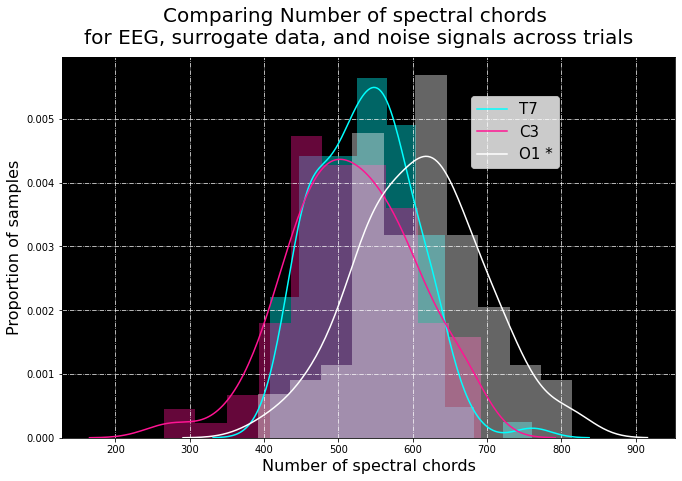

In [15]:
channels= ['T7', 'C3', 'O1']
peaks_function = 'fixed'
metric_to_graph = 'n_spectro_chords'
sf = 1000
data_O2 = np.load('data_examples/pareidolia_data_'+channels[0]+'.npy')
data_T8 = np.load('data_examples/pareidolia_data_'+channels[1]+'.npy')
data_C4 = np.load('data_examples/pareidolia_data_'+channels[2]+'.npy')
data_all = [data_O2, data_T8, data_C4]
colors = ['cyan', 'deeppink', 'white', 'blue', 'orange', 'yellow'] 


graph_conditions(data_all, sf = sf, conditions = channels, metric_to_graph=metric_to_graph, 
                 peaks_function = peaks_function, precision = 0.5, savefolder = '_', tag = '_', 
                 low_cut = 0.5, high_cut = 150, colors = colors, save = False, display = True,
                n_harmonic_peaks = 7, min_notes=3, cons_limit=0.1)

## Using EEG signal from muse headband dataset

<img src="images/muse_sensors.png" width=300 height=300 />

In [40]:
import pandas
df = pandas.read_csv('eeg/muse_test2.csv')
raw_TP9 = np.array(df['RAW_TP9'])
raw_TP9 = raw_TP9[~np.isnan(raw_TP9)]
raw_AF7= np.array(df['RAW_AF7'])
raw_AF7 = raw_AF7[~np.isnan(raw_AF7)]
raw_AF8 = np.array(df['RAW_AF8'])
raw_AF8 = raw_AF8[~np.isnan(raw_AF8)]
raw_TP10 = np.array(df['RAW_TP10'])
raw_TP10 = raw_TP10[~np.isnan(raw_TP10)]

"import pandas\ndf = pandas.read_csv('eeg/muse_test2.csv')\nraw_TP9 = np.array(df['RAW_TP9'])\nraw_TP9 = raw_TP9[~np.isnan(raw_TP9)]\nraw_AF7= np.array(df['RAW_AF7'])\nraw_AF7 = raw_AF7[~np.isnan(raw_AF7)]\nraw_AF8 = np.array(df['RAW_AF8'])\nraw_AF8 = raw_AF8[~np.isnan(raw_AF8)]\nraw_TP10 = np.array(df['RAW_TP10'])\nraw_TP10 = raw_TP10[~np.isnan(raw_TP10)]"

EEG signal is compared with ***brown, pink, white*** and ***blue noise*** simulated signals using ***'adapt'*** peaks_function

adapt  peaks freqs  [12.50036496350365, 13.083941605839415, 14.077737226277373, 15.5021897810219, 12.243065693430658]


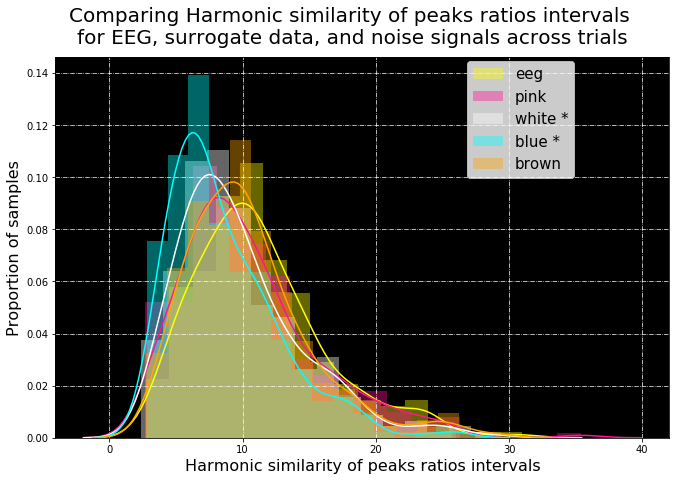

adapt  peaks freqs  [12.074817518248175, 13.251094890510949, 14.137591240875913, 15.395985401459853, 12.163868613138687]


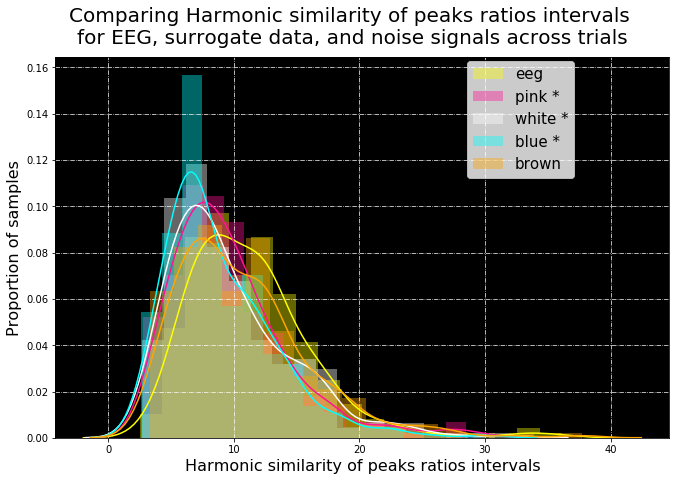

adapt  peaks freqs  [11.340875912408759, 13.144525547445255, 14.614963503649635, 15.545620437956204, 12.063138686131387]


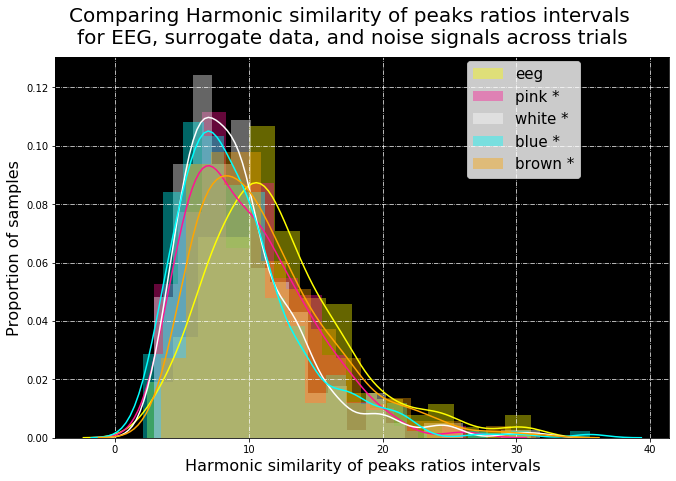

adapt  peaks freqs  [11.164963503649634, 13.336131386861314, 14.448175182481753, 15.582116788321168, 12.296350364963505]


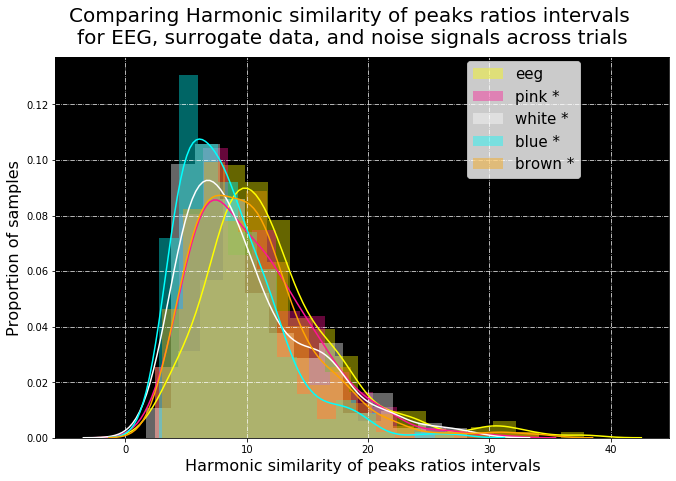

In [35]:
sf = 220
window = 2
channels = [raw_AF7, raw_AF8, raw_TP9, raw_TP10]
for ch in channels:
    data = ch
    data = slice_data(data, sf, window)
    peaks_functions = ['adapt']
    for p in peaks_functions:  
        colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
        conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
        metric_to_graph = 'matrix_harm_sim'
        data = np.array(data_sliced, dtype='float64')
        graph_surrogates(data, sf, conditions, metric_to_graph = metric_to_graph, peaks_function = p, precision = 0.5, 
                         savefolder = None, low_cut = 2, high_cut = (sf/2)-0.1, 
                        display = True, save = False, colors = colors, n_harmonic_peaks = 5)

adapt  peaks freqs  [12.50036496350365, 12.60036496350365, 12.357664233576642, 12.068978102189782, 13.855839416058394]


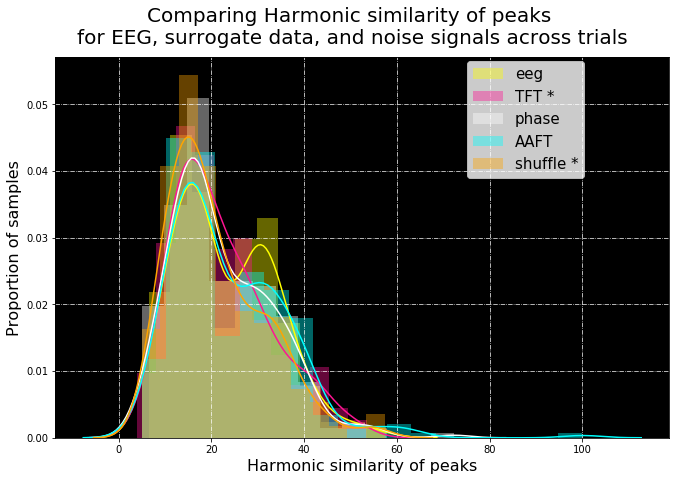

adapt  peaks freqs  [12.074817518248175, 12.136861313868613, 12.191605839416058, 12.018248175182482, 14.277372262773723]


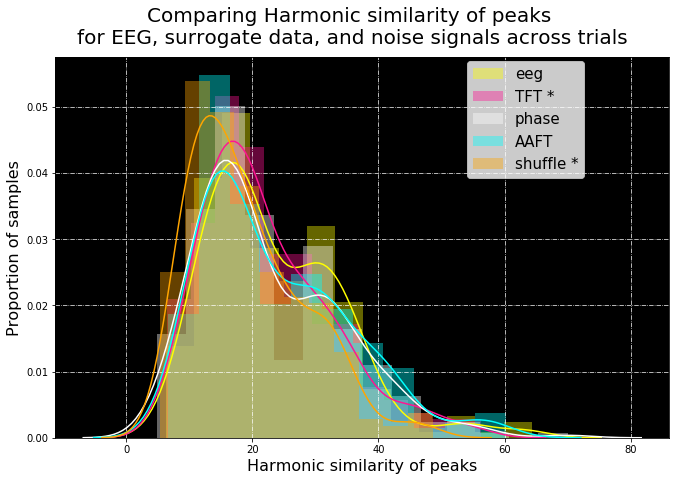

adapt  peaks freqs  [11.340875912408759, 11.400729927007298, 11.62080291970803, 11.91058394160584, 14.318613138686132]


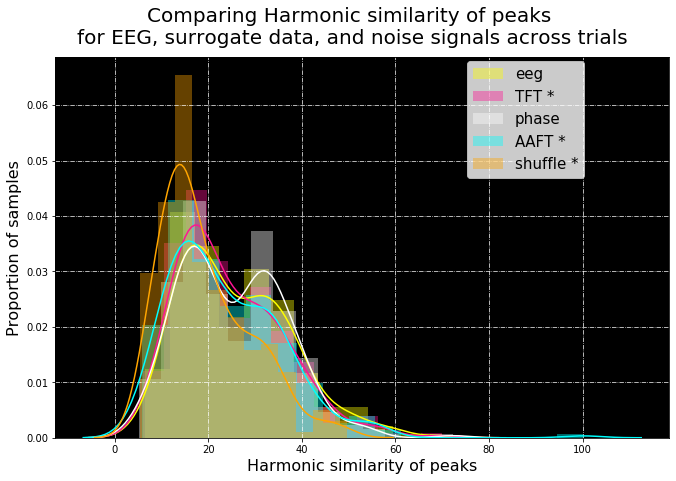

adapt  peaks freqs  [11.164963503649634, 11.238686131386862, 11.37153284671533, 11.583941605839415, 14.195620437956206]


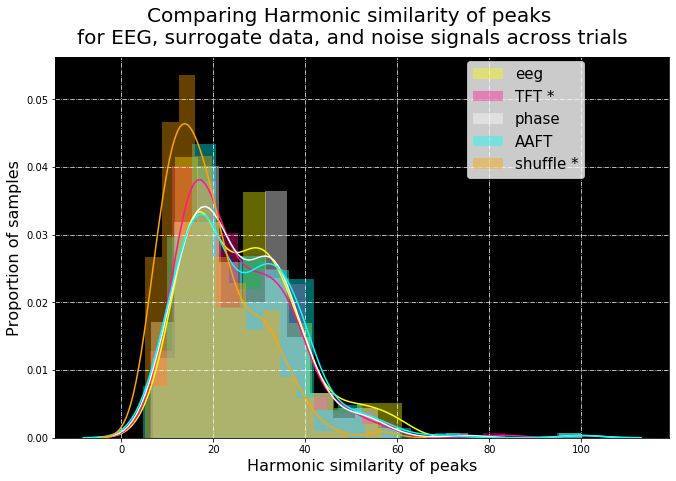

In [37]:
sf = 220
window = 2
channels = [raw_AF7, raw_AF8, raw_TP9, raw_TP10]
for ch in channels:
    data = ch
    data = slice_data(data, sf, window)
    peaks_functions = ['adapt']
    for p in peaks_functions:  
        colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
        conditions = ['eeg', 'TFT', 'phase', 'AAFT', 'shuffle']
        metric_to_graph = 'harmsim'
        graph_surrogates(data, sf, conditions, metric_to_graph = metric_to_graph, peaks_function = p, precision = 0.5, 
                         savefolder = None, low_cut = 2, high_cut = (sf/2)-0.1, 
                        display = True, save = False, colors = colors)


## Using intracranial EEG

The data was downloaded from : https://openneuro.org/datasets/ds003374/versions/1.1.1

*Dataset of neurons and intracranial EEG from human amygdala during aversive dynamic visual stimulation*

In [17]:
path = 'data_examples/'
data = mne.io.read_raw_edf(path + 'ieeg_amyg.edf', preload = True)
raw_data = data.load_data()
raw_data = raw_data.get_data()

Extracting EDF parameters from C:\Users\Dell\GitHub\biotuner\examples\data_examples\ieeg_amyg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1043999  =      0.000 ...   522.000 secs...


harmonic_peaks  peaks freqs  [6.627234042553192, 7.00127659574468, 27.21489361702128, 47.04, 5.648510638297871]


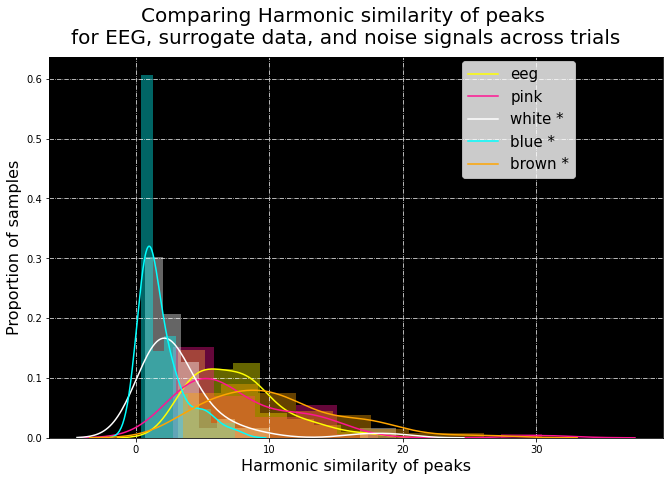

In [18]:
sf = 2000
data = raw_data[1][100000:1900000]
window = 10
data = slice_data(data, sf, window)

peaks_functions = ['harmonic_peaks']
for p in peaks_functions:  
    colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
    conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
    metric_to_graph = 'harmsim'
    graph_surrogates(data, sf, conditions, metric_to_graph = metric_to_graph, peaks_function = p, precision = 0.1, 
                     savefolder = None, low_cut = 2, high_cut = 200, 
                    display = True, save = False, colors = colors, n_harmonic_peaks = 5, min_harms = 1)

EEMD  peaks freqs  [7.651599999999999, 22.9028, 30.3064, 38.909200000000006, 15.683600000000002]


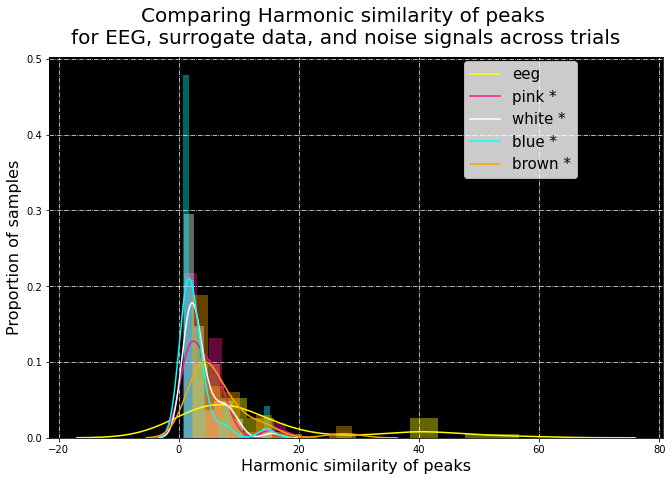

In [21]:
peaks_functions = ['EEMD']
for p in peaks_functions:  
    colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
    conditions = ['eeg', 'pink', 'white', 'blue', 'brown']
    metric_to_graph = 'harmsim'
    graph_surrogates(data, sf, conditions, metric_to_graph = metric_to_graph, peaks_function = p, precision = 0.1, 
                     savefolder = None, low_cut = 2, high_cut = 200, 
                    display = True, save = False, colors = colors, n_harmonic_peaks = 5, min_harms = 1)

fixed  peaks freqs  [12.676000000000002, 12.7684, 12.6944, 15.2024]


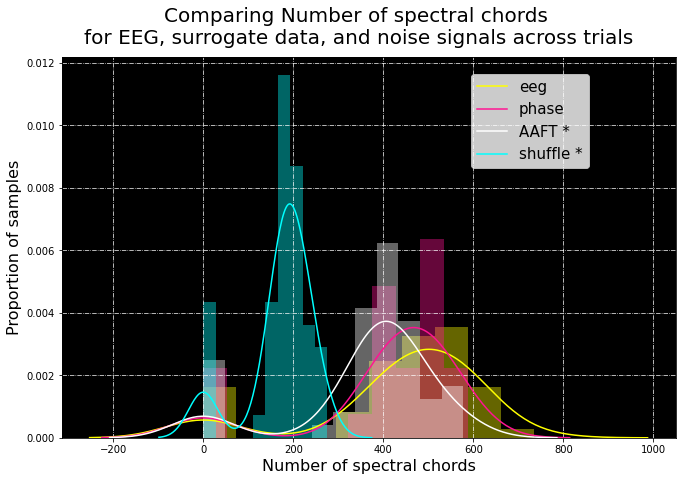

In [19]:
peaks_functions = ['fixed']
for p in peaks_functions:  
    colors = ['yellow', 'deeppink', 'white', 'cyan', 'orange']
    conditions = [ 'eeg', 'phase', 'AAFT', 'shuffle']
    metric_to_graph = 'n_spectro_chords'
    graph_surrogates(data, sf, conditions, metric_to_graph = metric_to_graph, peaks_function = p, precision = 0.1, 
                     savefolder = None, low_cut = 2, high_cut = 200, 
                    display = True, save = False, colors = colors, n_harmonic_peaks = 5, min_harms = 1, 
                    min_notes=3, cons_limit=0.1)
